# Машинное обучение, ФЭН ВШЭ

# Практическое задание 3

## Общая информация

Дата выдачи: 29.10.2017

Срок сдачи: 23:59MSK 12.11.2017

### О задании

Практическое задание 5 посвящено использованию ядер в методах машинного обучения. В рамках данного задания вы:
 * исследуете вид разделяющих поверхностей в исходном пространстве в зависимости от типа используемов ядра и значений его параметров
 * используете SVD для сжатия картинок
 * исследуете обычный и ядровый PCA

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW3_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW3_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

## SVM

**1. (0.5 баллов)** Сгенерируйте три случайные двумерные выборки для бинарной классификации (хотя бы по 400 точек в каждой):
- с линейно разделимыми классами;
- с хорошо разделимыми классами, но не линейно разделимыми;
- с плохо разделимыми классами.

Визуализируйте полученные выборки на плоскости.

Для генерации случайной выборки можно использовать функции из модуля [sklearn.datasets](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets).

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

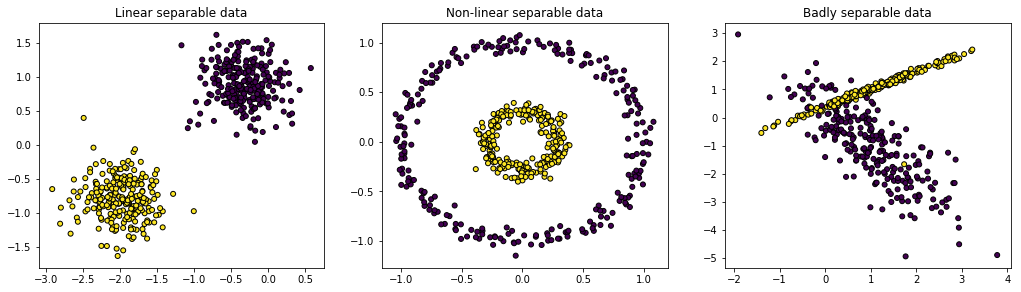

In [2]:
n_samples = 500
fig = plt.figure(figsize=(15, 4))
plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=.95)
plt.subplot(131) 
plt.title("Linear separable data")
Xb, yb = make_blobs(n_samples=n_samples, n_features=2, centers=2, 
           cluster_std=0.3, center_box=(-2.0, 2.0), shuffle=True, random_state=1)
plt.scatter(Xb[:, 0], Xb[:, 1], marker='o', c=yb, s=25, edgecolor='k')
           
plt.subplot(132)
plt.title("Non-linear separable data")
Xc, yc = make_circles(n_samples=n_samples, factor=.3, noise=.05, random_state=1)
plt.scatter(Xc[:, 0], Xc[:, 1], marker='o', c=yc,s=25, edgecolor='k')         
           
plt.subplot(133)
plt.title("Badly separable data")
Xl, yl = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1, random_state=42)
plt.scatter(Xl[:, 0], Xl[:, 1], marker='o', c=yl, s=25, edgecolor='k')
plt.show()

Рассмотрим(https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture13-features.pdf) двойственную задачу метода опорных векторов:
$$\begin{cases}
\sum_{i=1}^l \lambda_i - \frac{1}{2} \sum_{i, \, j =1}^l \lambda_i \lambda_j y_i y_j \langle x_i, x_j\rangle \to \max_\lambda,\\
0 \le \lambda_i \le C, i = \overline{1, l},\\
\sum_{i=1}^l \lambda_i y_i = 0.
\end{cases}$$

После решения данной задачи прогнозы для новых объектов строятся следующим образом: $a(x) = \text{sign} \left( \sum_{i=1}^l \lambda_i y_i \langle x_i, x \rangle + b \right).$

Заметим, что и оптимизационная задача, и формула итогового классификатора зависят лишь от скалярных произведений объектов, а потому в данном методе можно использовать ядра для восстановления нелинейных зависимостей.

**2. (1.5 балла)** Обучите на сгенерированных ранее двумерных выборках [ядровой SVM](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) с использованием следующих типов ядер (для различных значений гиперпараметра $C$):
- линейное: $K(x, z) = \langle x, z \rangle$;
- полиномиальное: $K(x, z) = (\gamma \langle x, z \rangle + 1)^d$ (для различных значений $\gamma, d$);
- гауссовское: $K(x, z) = \exp(-\gamma \|x - z\|^2)$ (для различных значений $\gamma$).

Визуализируйте разделяющую поверхность и разделяющую полосу:
 - для модели с линейным ядром для различных значений $C$;
 - для моделей, использующих полиномиальное и гауссовское ядро, соответствующих недообучению, нормальному поведению и переобучению.

In [3]:
from sklearn.svm import SVC

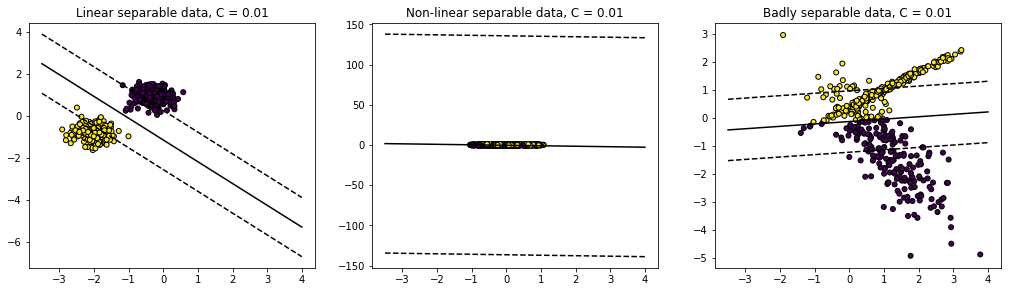

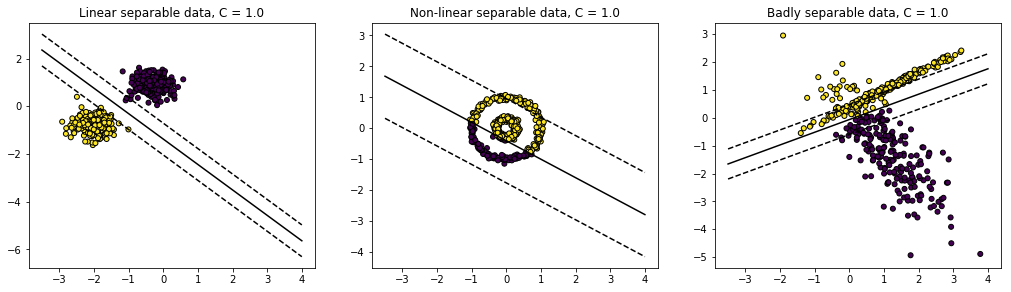

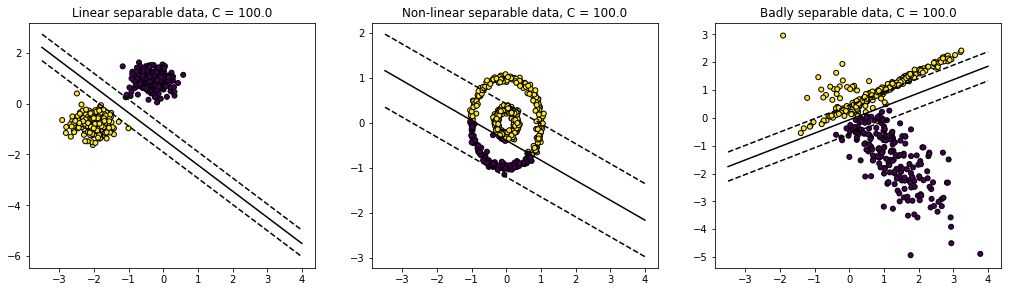

In [4]:
C = np.array([0.01,1.0, 100.0])
# linear kernel
for i in C:
    lin_c = SVC(C=i, kernel = 'linear', random_state = 3).fit(Xc, yc) 
    lin_b = SVC(C=i, kernel = 'linear', random_state = 3).fit(Xb, yb)
    lin_l = SVC(C=i, kernel = 'linear', random_state = 3).fit(Xl, yl)
    models = [[lin_b,Xb],[lin_c,Xc],[lin_l,Xl]]
    xxl,yyl, yy_downl, yy_upl = [], [], [], []
    for m in range(len(models)):
        w = models[m][0].coef_[0]
        a = -w[0] / w[1]
        xx = np.linspace(-3.5, 4)
        yy = a * xx - (models[m][0].intercept_[0]) / w[1]
        margin = 1 / np.sqrt(np.sum(models[m][0].coef_ ** 2))
        yy_down = yy - np.sqrt(1 + a ** 2) * margin
        yy_up = yy + np.sqrt(1 + a ** 2) * margin
        xxl.append(xx)
        yyl.append(yy)
        yy_downl.append(yy_down)
        yy_upl.append(yy_up)
    fig = plt.figure(figsize=(15, 4))
    plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=.95)
    plt.subplot(131) 
    plt.title("Linear separable data, C = %s"%i)
    plt.plot(xxl[0], yyl[0], 'k-')
    plt.plot(xxl[0], yy_downl[0], 'k--')
    plt.plot(xxl[0], yy_upl[0], 'k--')
    plt.scatter(models[0][1][:, 0], models[0][1][:, 1], marker='o', 
                c=models[0][0].predict(models[0][1]), s=25, edgecolor='k')
    plt.subplot(132)
    plt.title("Non-linear separable data, C = %s"%i)
    plt.plot(xxl[1], yyl[1], 'k-')
    plt.plot(xxl[1], yy_downl[1], 'k--')
    plt.plot(xxl[1], yy_upl[1], 'k--')
    plt.scatter(models[1][1][:, 0], models[1][1][:, 1], marker='o', 
                c=models[1][0].predict(models[1][1]), s=25, edgecolor='k')         
    plt.subplot(133)
    plt.title("Badly separable data, C = %s"%i)
    plt.plot(xxl[2], yyl[2], 'k-')
    plt.plot(xxl[2], yy_downl[2], 'k--')
    plt.plot(xxl[2], yy_upl[2], 'k--')
    plt.scatter(models[2][1][:, 0], models[2][1][:, 1], marker='o', 
                c=models[2][0].predict(models[2][1]), s=25, edgecolor='k') 
    plt.show()    


In [5]:
# fit clf, plot clf with margins for underfitting, normal, overfitting
def plot_kernel(c, kernel, gamma, degree, X, y,subnum, title):
    # fit clf
    clf = SVC(C=c, kernel=kernel, gamma=gamma, degree=degree, random_state=3).fit(X, y)
    # plot result
    x_min, x_max, y_min, y_max = X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max()
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape(XX.shape)
    # Put the result into a color plot
    plt.subplot(subnum) 
    plt.title(kernel+', '+title+ ", C = %s, gamma=%s, d=%s"%(c,gamma,degree), fontsize='small')
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
                linestyles=['--', '-', '--'], levels=[-.5, 0, .5])
    plt.scatter(X[:, 0], X[:, 1], marker='o', 
                c=clf.predict(X), s=25, edgecolor='k')

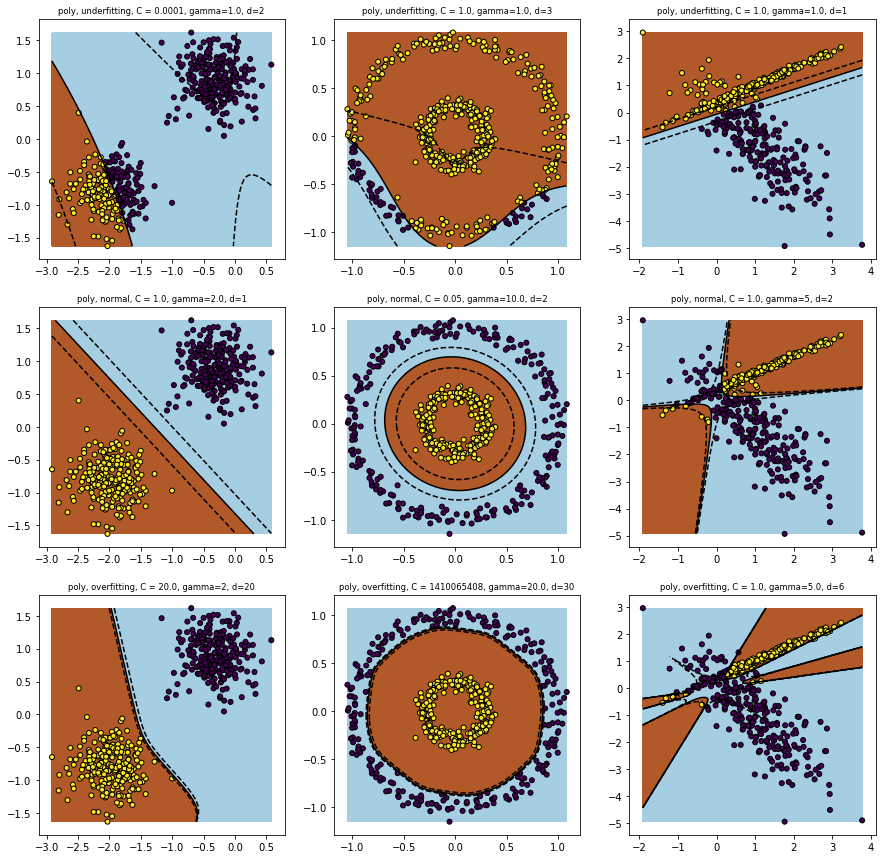

In [46]:
# polynomial kernel
plt.figure(figsize=(15, 15))
plot_kernel(c=.0001, kernel='poly', gamma=1.,degree=2, X=Xb, y=yb, subnum=331, title='underfitting')
plot_kernel(c=1., kernel='poly', gamma=1.,degree=3, X=Xc, y=yc, subnum=332, title='underfitting')
plot_kernel(c=1., kernel='poly', gamma=1.,degree=1, X=Xl, y=yl, subnum=333, title='underfitting')
plot_kernel(c=1., kernel='poly', gamma=2.,degree=1, X=Xb, y=yb, subnum=334, title='normal')
plot_kernel(c=.05, kernel='poly', gamma=10.,degree=2, X=Xc, y=yc, subnum=335, title='normal')
plot_kernel(c=1., kernel='poly', gamma=5, degree=2, X=Xl, y=yl, subnum=336, title='normal')
plot_kernel(c=20., kernel='poly', gamma=2,degree=20, X=Xb, y=yb, subnum=337, title='overfitting')
plot_kernel(c=np.power(10,10), kernel='poly', gamma=20.,degree=30, X=Xc, y=yc, subnum=338, title='overfitting')
plot_kernel(c=1., kernel='poly', gamma=5.,degree=6, X=Xl, y=yl, subnum=339, title='overfitting')

In [47]:
# just fit rbf kernel 
gamma = np.array([1,5,10])
C = np.array([0.01, 10.0])
# polynomial kernel
for i in C:
    for j in gamma:
        poly_c = SVC(C=i, kernel='rbf', gamma=j, random_state=3).fit(Xc, yc) 
        poly_b = SVC(C=i, kernel='rbf', gamma=j, random_state=3).fit(Xb, yb)
        poly_l = SVC(C=i, kernel='rbf', gamma=j, random_state=3).fit(Xl, yl)

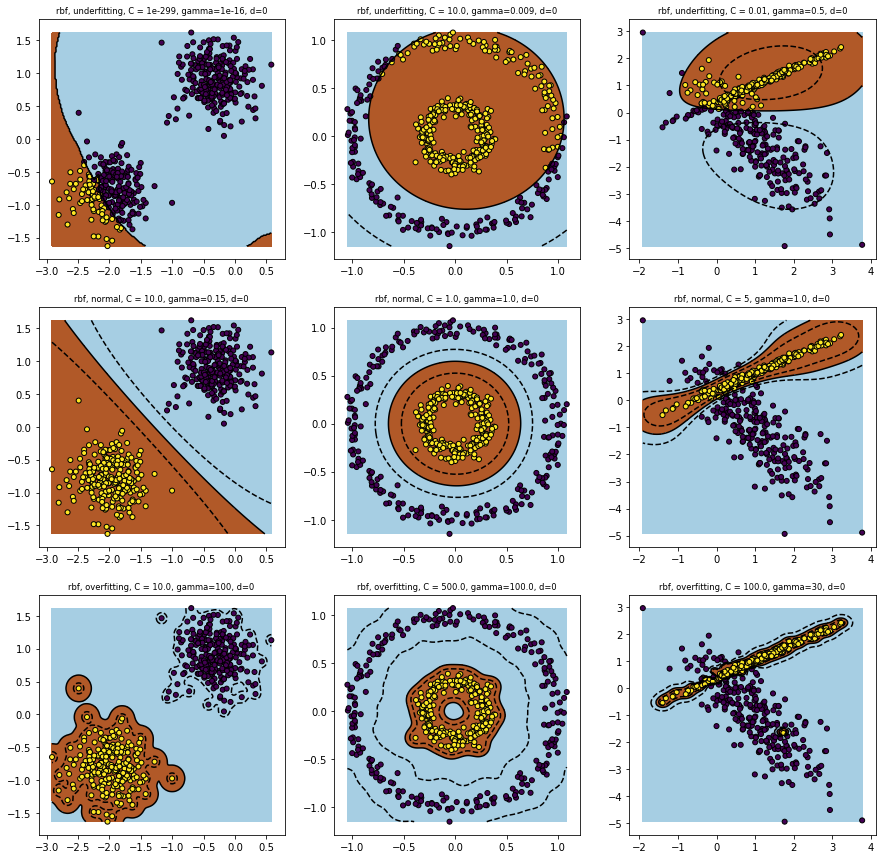

In [48]:
# rbf kernel
plt.figure(figsize=(15, 15))
plot_kernel(c=np.power(.1,299), kernel='rbf', gamma=np.power(.1,16),degree=0, X=Xb, y=yb, subnum=331, title='underfitting')
plot_kernel(c=10., kernel='rbf', gamma=0.009,degree=0, X=Xc, y=yc, subnum=332, title='underfitting')
plot_kernel(c=0.01, kernel='rbf', gamma=.5,degree=0, X=Xl, y=yl, subnum=333, title='underfitting')
plot_kernel(c=10., kernel='rbf', gamma=0.15,degree=0, X=Xb, y=yb, subnum=334, title='normal')
plot_kernel(c=1., kernel='rbf', gamma=1.,degree=0, X=Xc, y=yc, subnum=335, title='normal')
plot_kernel(c=5, kernel='rbf', gamma=1.,degree=0, X=Xl, y=yl, subnum=336, title='normal')
plot_kernel(c=10., kernel='rbf', gamma=100,degree=0, X=Xb, y=yb, subnum=337, title='overfitting')
plot_kernel(c=500., kernel='rbf', gamma=100.,degree=0, X=Xc, y=yc, subnum=338, title='overfitting')
plot_kernel(c=100., kernel='rbf', gamma=30,degree=0, X=Xl, y=yl, subnum=339, title='overfitting')

**3. (1 балл)** Ответьте на следующие вопросы:
 - Как ведет себя SVM с полиномиальным ядром в зависимости от значений гиперпараметра $C$, степени ядра $d$ и параметра $\gamma$?
 - Как ведет себя SVM с гауссовским ядром в зависимости от значений гиперпараметра $C$ и $\gamma$?

**Ответ:** (используя графики из п.2)
- параметр С сам по себе не участвует в ядре, это штраф за неправильную классификацию и превышение отступа. Поэтому, чем выше значение параметра С, тем более узкой будет ширина разделяющей полосы (margins)
- для гауссовского ядра с ростом параметра $\gamma$ происходит более точная настройка под данные (что при очень больших значениях параметра приводит к переобучению). Это и понятно, ведь $\gamma$ в формуле ядра обратно пропорционален дисперсии нормального распределения: поэтому чем больше $\gamma$, тем ниже Var и точнее подгонка под данные (больше плотности сконцентрированно в матожидании, более легкие хвосты)
- для полиномиального ядра параметр $d$ отвечает за размерность, в которую ядро переводит пространство признаков: для $d=1$ получим линейное ядро, при увеличении $d$ мы ищем разделяющую гиперплоскость в простарнстве более высокой размерности, находя нелинейные признаки и увеличивая сложность модели. Поэтому очень большие значения $d$ приводят к переобучению. 
- для полиномиального ядра параметр $\gamma$ отвечает за коэффициенты при полиноме, поэтому от этого параметра наблюдается менее очевидная зависимость. В целом при увеличении $\gamma$ SVM более склонен к тонкой настройке под выборку и к переобучению (аналогично большим весам в задаче регрессии). 

**4. (1.5 балл)** Обучите модели с использованием ядер из п. 2 для задачи бинарной классификации [Predicting a Biological Response](https://www.kaggle.com/c/bioresponse) (используйте файл train.csv) для значения $C=1.$ Для оценки качества разбейте выборку на обучающую и тестовую в отношении 50/50. Постройте модель, позволяющую достичь значения accuracy, равного 0.75, на тестовой выборке. Позволяет ли использование ядер достичь лучшего качества по сравнению с линейной моделью?

In [49]:
df = pd.read_csv("train.csv")

In [50]:
df.shape

(3751, 1777)

In [51]:
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [52]:
from sklearn.model_selection import train_test_split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Activity', axis=1), df['Activity'], test_size=0.5, random_state=42)

In [54]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [55]:
# fit some default models
linear = SVC(kernel='linear', random_state=3).fit(X_train, y_train)
polynom = SVC(kernel='poly', random_state=3).fit(X_train, y_train)
gauss = SVC(kernel='rbf', random_state=3).fit(X_train, y_train)

In [56]:
# quality of some default models
print('linear kernel, roc-auc %s'%roc_auc_score(y_test, linear.predict(X_test)))
print('linear kernel, accuracy %s'%accuracy_score(y_test, linear.predict(X_test)))
print('polynomial kernel, roc-auc %s'%roc_auc_score(y_test, polynom.predict(X_test)))
print('polynomial kernel, accuracy %s'%accuracy_score(y_test, polynom.predict(X_test)))
print('rbf kernel, roc-auc %s'%roc_auc_score(y_test, gauss.predict(X_test)))
print('rbf kernel, accuracy %s'%accuracy_score(y_test, gauss.predict(X_test)))

linear kernel, roc-auc 0.73135352031
linear kernel, accuracy 0.733475479744
polynomial kernel, roc-auc 0.5
polynomial kernel, accuracy 0.559168443497
rbf kernel, roc-auc 0.693349916947
rbf kernel, accuracy 0.690831556503


In [57]:
# find good model with grid search
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.1,0.5, 1], 'gamma':[1,2,3,4], 'degree':[2,3]}
svc = SVC(random_state=3)
clf = GridSearchCV(svc, parameters)

In [58]:
model = clf.fit(X_train, y_train)

In [59]:
model.best_estimator_

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma=1, kernel='linear',
  max_iter=-1, probability=False, random_state=3, shrinking=True,
  tol=0.001, verbose=False)

In [60]:
# linear model
print('my model, roc-auc %s'%roc_auc_score(y_test, model.predict(X_test)))
print('my model, accuracy %s'%accuracy_score(y_test, model.predict(X_test)))

my model, roc-auc 0.753755808203
my model, accuracy 0.758528784648


In [100]:
n_features = len(X_train.columns)

In [103]:
# better non-linear model with good quality
sas2 = SVC(C=10, kernel='rbf', gamma=3/n_features, random_state=3).fit(X_train, y_train)
print('rbf kernel, roc-auc %s'%roc_auc_score(y_test, sas2.predict(X_test)))
print('rbf kernel, accuracy %s'%accuracy_score(y_test, sas2.predict(X_test)))

rbf kernel, roc-auc 0.767207324763
rbf kernel, accuracy 0.771855010661


**Ответ:** использование гауссовского ядра позволяет достичь лучшего качества на тестовой выборке, чем у линейной модели.  

## SVD

Скачайте картинку и положите в каталог рядом с ноутбуком:

In [70]:
from PIL import Image
from scipy import misc
import matplotlib.pyplot as plt
import sys
%matplotlib inline

img = misc.imread(r'art.jpg')

Посмотрим на нее:

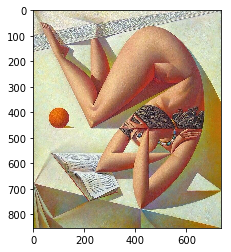

In [71]:
plt.imshow(img);

Для удобства оставим только один канал.

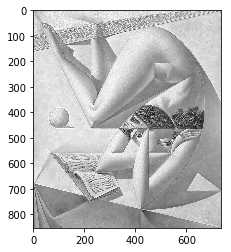

In [72]:
img = img[:,:,0]
plt.imshow(img, cmap='gray');

**5. (1 балла)** 

Главные компоненты - это матрицы вида  $u_i\sigma_iv_i^T$, где  $u_i, v_i$ это столбцы матриц $U$ и $V$ из сингулярного разложения; $\sigma_i$ соответсвующее сингулярное число. Визуализуйте первые и последние несколько компонент. Сделайте выводы.

In [73]:
# singular decomposition
u, s, v = np.linalg.svd(img, full_matrices=False)

In [74]:
print(u.shape, s.shape, v.shape)

(853, 736) (736,) (736, 736)


In [75]:
# первые 30 главных компонент
first30 = np.dot(np.dot(u[:,:30],np.diag(s[:30])), v[:30, :])
# последние 30 главных компонент
last30 = np.dot(np.dot(u[:,-30:],np.diag(s[-30:])), v[-30:, :])

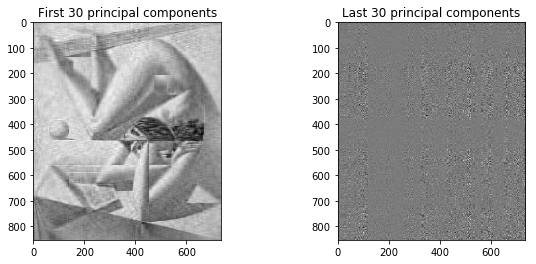

In [76]:
plt.figure(figsize=(10, 4))
plt.subplot(121) 
plt.title("First 30 principal components")
plt.imshow(first30, cmap='gray')
plt.subplot(122) 
plt.title("Last 30 principal components")
plt.imshow(last30, cmap='gray')

**Вывод:** при визуализации первых и последних 30 главных компонент можно убедиться, что 
- первые 30 главных компонент вбирают в себя наибольшую часть дисперсии, наибольший разброс, что уже позволяет хорошо приблизить картинку
- последние 30 главных компонент почти ничего не объясняют, в них собрана лишь малая часть дисперсии, поэтому картинка показывает шум. 

**6. (1 балл)** 

Как вам кажется, сколько первых компонент нужно взять для достаточно хорошего восстановления исходного изображения? Используйте график объясненной дисперсии для вашего выбора. Покажите полученные картинки для разного числа компонент.  Во сколько раз меньше памяти потребуется для хранения?  Вес объекта можно узнат командой * sys.getsizeof(x) *


In [77]:
var_list = s*s
sum_var = [] # explained variance
cumsum=0
for i in var_list:
    cumsum+=i
    sum_var.append(cumsum) 

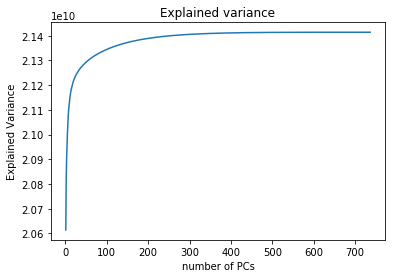

In [78]:
x = range(1,len(sum_var)+1,1)
#plt.figure(figsize=(4, 3))
plt.title('Explained variance')
plt.plot(x, sum_var)
plt.xlabel('number of PCs')
plt.ylabel('Explained Variance')

**Вывод:** по графику объясненной дисперсии видно, что после 300 главных компонент объясненная дисперсия почти не растет, поэтому достаточно будет взять 300 главных компонент

In [79]:
def plot_comps(num, subplot):
    image = np.dot(np.dot(u[:,:num],np.diag(s[:num])), v[:num, :])
    plt.subplot(subplot) 
    plt.title("First %s principal components"%num)
    plt.imshow(image, cmap='gray')

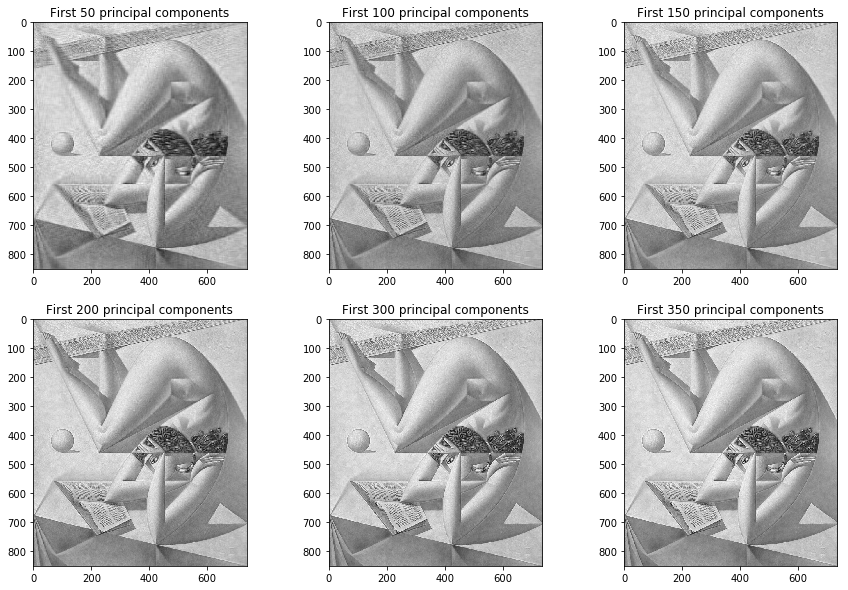

In [80]:
plt.figure(figsize=(15, 10))
plot_comps(50,231)
plot_comps(100,232)
plot_comps(150,233)
plot_comps(200,234)
plot_comps(300,235)
plot_comps(350,236)

**Вывод:** по картинкам видно, что уже при 300 главных компонентах достигается хорошее приближение исходной картинки, и разница между 300 и 350 главными компонентами почти незаметна. Поэтому возьмем 300 главных компонент.

- Исходная картинка хранится в виде матрицы элементов типа int, их нужно привести к тому же типу, что у элементов сокращенной матрицы, чтобы матрицы были сравнимы
- Сокращенная картинка, для которой мы сделали SVD, может хранится в виде трех объектов: матриц U, V и вектора s (обрезанных), что хорошо сокращает занимаемую память:

In [81]:
npc = 300
new_memory = u[:,:npc].nbytes + s[:npc].nbytes + v[:npc,:].nbytes 
new_memory

3816000

In [82]:
print(type(s[0]), type(u[0,0]), type(v[0,0])) # Типы элементов матрицы новой картинки

<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


In [85]:
# приведем элементы матрицы исходной картинки к типу np.float64
base_img = img.astype(np.float64)
old_memory = base_img.nbytes
old_memory

5022464

In [86]:
print("для хранения потребуется памяти в ", old_memory/new_memory, "раз меньше")

для хранения потребуется памяти в  1.3161593291404612 раз меньше


## PCA

Рассмотрим нелиненый датасет. Попробуем решить задачу классификации, используя представление точек, полученнуе с помощью различных версий PCA.

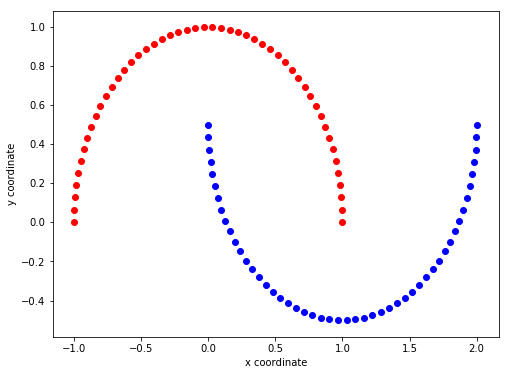

In [87]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=654)

plt.figure(figsize=(8,6))

plt.scatter(X[y==0, 0], X[y==0, 1], color='red')
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue')


plt.ylabel('y coordinate')
plt.xlabel('x coordinate')

plt.show()

### Linear PCA

**7. (1 балл)** 

Постройте графики, полученные проекцией на одну и две главные компоненты. Сохраняйте цвет для разных классов. 


In [88]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(X)
X_1 = pca.transform(X)

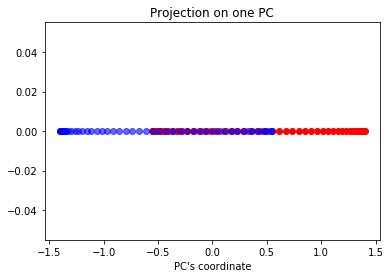

In [89]:
ar, ar1 = X_1[y==0, 0], X_1[y==1, 0] 
plt.plot(ar, np.zeros_like(ar), 'o', color='red')
plt.plot(ar1, np.zeros_like(ar1), 'o', color='blue', alpha=0.6)
plt.xlabel("PC's coordinate")
plt.title('Projection on one PC')
plt.show()

In [90]:
pca2 = PCA(n_components=2)
pca2.fit(X)
X_2 = pca2.transform(X)

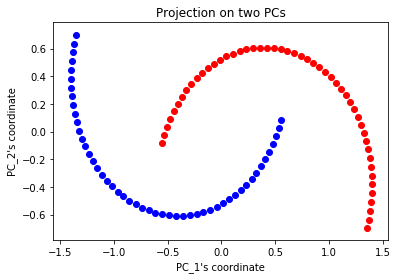

In [91]:
plt.scatter(X_2[y==0, 0], X_2[y==0, 1], color='red')
plt.scatter(X_2[y==1, 0], X_2[y==1, 1], color='blue')
plt.ylabel("PC_2's coordinate")
plt.xlabel("PC_1's coordinate")
plt.title("Projection on two PCs")
plt.show()

### RBF PCA

**8. (0.5 балла)** 
Допишите в месте "Your code here" построение матрицы Грамма для RBF ядра, с параметром gamma. Обратите внимание, что выше в коде уже получена матрица попарных расстояний sq_dists

In [92]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

In [93]:
def stepwise_kpca(X, gamma, n_components):
    """
    X: A MxN dataset as NumPy array where the samples are stored as rows (M), features as columns (N).
    gamma: coefficient for the RBF kernel.
    n_components: number of components to be returned.

    """
    # Calculating the squared Euclidean distances for every pair of points
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Converting the pairwise distances into a symmetric MxM matrix.
    mat_sq_dists = squareform(sq_dists)

    K =  np.exp(-gamma*mat_sq_dists)

    # Centering the symmetric NxN kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenvalues in descending order with corresponding
    # eigenvectors from the symmetric matrix.
    eigvals, eigvecs = eigh(K)

    # Obtaining the i eigenvectors that corresponds to the i highest eigenvalues.
    X_pc = np.column_stack((eigvecs[:,-i] for i in range(1,n_components+1)))

    return X_pc

**9. (2 балл)**  
Постройте графики, полученные проекцией на одну и две главные компоненты. Сохраняйте цвет для разных классов. Подберите такой параметр gamma, что выборка стала линейно разделимой.

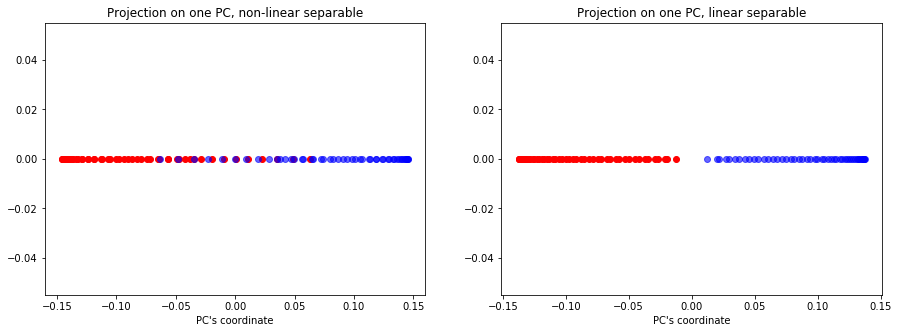

In [94]:
plt.figure(figsize=(15,5))
plt.subplot(121)
X_3 = stepwise_kpca(X, gamma=5, n_components=1)
ar, ar1 = X_3[y==0, 0], X_3[y==1, 0] 
plt.plot(ar, np.zeros_like(ar), 'o', color='red')
plt.plot(ar1, np.zeros_like(ar1), 'o', color='blue', alpha=0.6)
plt.xlabel("PC's coordinate")
plt.title('Projection on one PC, non-linear separable')
plt.subplot(122)
X_3 = stepwise_kpca(X, gamma=15, n_components=1)
ar, ar1 = X_3[y==0, 0], X_3[y==1, 0] 
plt.plot(ar, np.zeros_like(ar), 'o', color='red')
plt.plot(ar1, np.zeros_like(ar1), 'o', color='blue', alpha=0.6)
plt.xlabel("PC's coordinate")
plt.title('Projection on one PC, linear separable')
plt.show()

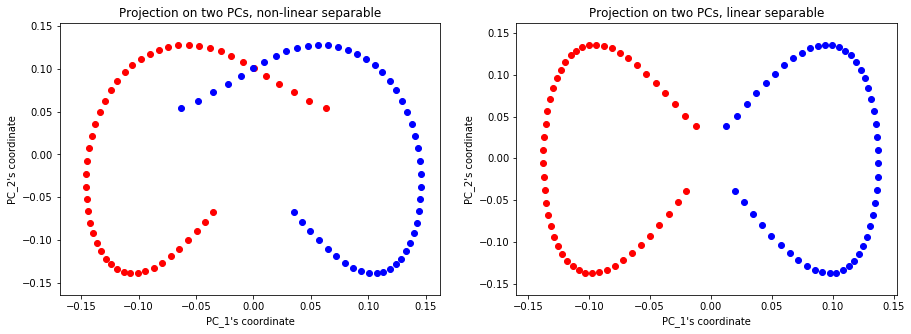

In [95]:
plt.figure(figsize=(15,5))
plt.subplot(121)
X_4 = stepwise_kpca(X, gamma=5, n_components=2)
plt.scatter(X_4[y==0, 0], X_4[y==0, 1], color='red')
plt.scatter(X_4[y==1, 0], X_4[y==1, 1], color='blue')
plt.ylabel("PC_2's coordinate")
plt.xlabel("PC_1's coordinate")
plt.title("Projection on two PCs, non-linear separable")
plt.subplot(122)
X_4 = stepwise_kpca(X, gamma=15, n_components=2)
plt.scatter(X_4[y==0, 0], X_4[y==0, 1], color='red')
plt.scatter(X_4[y==1, 0], X_4[y==1, 1], color='blue')
plt.ylabel("PC_2's coordinate")
plt.xlabel("PC_1's coordinate")
plt.title("Projection on two PCs, linear separable")
plt.show()

### Ваши мысли о задании:

### Здесь можете поделиться картинкой